In [1]:
# ===================================================
# DUAL CNN WITH CROSS-ATTENTION
# MULTI-MODAL PHISHING DETECTION: URL + HTML
# ===================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup
import re
from datetime import datetime
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("DUAL CNN WITH CROSS-ATTENTION")
print("MULTI-MODAL PHISHING DETECTION: URL + HTML")
print("="*60)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

DUAL CNN WITH CROSS-ATTENTION
MULTI-MODAL PHISHING DETECTION: URL + HTML
Started at: 2025-12-11 01:38:10


In [2]:
# ==============
# GPU SETUP
# ==============


print("GPU SETUP")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("WARNING: GPU not available, using CPU")

print(f"Device: {device}")

GPU SETUP
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU: NVIDIA GeForce GTX 1650
Device: cuda


In [3]:
# =====================================
# LOAD PHRESHPHISH DATASET
# =====================================

print("LOADING PHRESHPHISH DATASET...")

from datasets import load_dataset

print("Loading dataset from cache...")
dataset = load_dataset("phreshphish/phreshphish", cache_dir='E:/.cache/huggingface')

print(f"Train samples: {len(dataset['train']):,}")
print(f"Test samples: {len(dataset['test']):,}")

# Extract URLs and labels 
print("\nExtracting URLs and labels...")
train_urls = dataset['train']['url']
train_labels = dataset['train']['label']
test_urls = dataset['test']['url']
test_labels = dataset['test']['label']

print(f"Done! {len(train_urls):,} train, {len(test_urls):,} test")

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

print(f"\nLabel distribution (train):")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    label_name = 'benign' if label == 0 else 'phish'
    print(f"  {label_name}: {count:,} ({count/len(y_train)*100:.1f}%)")



LOADING PHRESHPHISH DATASET...
Loading dataset from cache...
Train samples: 371,941
Test samples: 36,787

Extracting URLs and labels...
Done! 371,941 train, 36,787 test

Label distribution (train):
  benign: 253,189 (68.1%)
  phish: 118,752 (31.9%)


In [4]:
# ==========================
# HTML PREPROCESSING
# ==========================

print("\n" + "="*60)
print("HTML PREPROCESSING")
print("="*60)

import pickle
import os

# Paths for cached cleaned HTML
CACHE_DIR = '../../../data/processed/url-detection/'
os.makedirs(CACHE_DIR, exist_ok=True)

TRAIN_HTML_CLEANED_PATH = os.path.join(CACHE_DIR, 'train_html_cleaned.pkl')
TEST_HTML_CLEANED_PATH = os.path.join(CACHE_DIR, 'test_html_cleaned.pkl')

# Check if cached cleaned HTML exists
if os.path.exists(TRAIN_HTML_CLEANED_PATH) and os.path.exists(TEST_HTML_CLEANED_PATH):
    print("\nFound cached cleaned HTML! Loading from disk...")
    
    with open(TRAIN_HTML_CLEANED_PATH, 'rb') as f:
        train_html_cleaned = pickle.load(f)
    
    with open(TEST_HTML_CLEANED_PATH, 'rb') as f:
        test_html_cleaned = pickle.load(f)
    
    print(f"Loaded train_html_cleaned: {len(train_html_cleaned):,} samples")
    print(f"Loaded test_html_cleaned: {len(test_html_cleaned):,} samples")
    print(f"Sample: {train_html_cleaned[0][:150]}...")
    
else:
    print("\nNo cached data found. Processing HTML from scratch...")
    print("This will take a while...")
    
    def clean_html(html):
        """Clean HTML content for tokenization"""
        if not html or len(html) == 0:
            return ""
        
        try:
            if len(html) > 50000:
                html = html[:50000]
            
            soup = BeautifulSoup(html, 'lxml')
            
            for tag in soup(['script', 'style', 'noscript', 'svg']):
                tag.decompose()
            
            text = soup.get_text(separator=' ', strip=True)
            
            forms = soup.find_all('form')[:3]
            form_actions = ' '.join([form.get('action', '')[:50] for form in forms])
            
            links = soup.find_all('a')[:5]
            link_hrefs = ' '.join([link.get('href', '')[:30] for link in links])
            
            title = soup.title.string if soup.title else ""
            if title and len(title) > 100:
                title = title[:100]
            
            combined = f"{title} {text[:5000]} {form_actions} {link_hrefs}"
            combined = re.sub(r'\s+', ' ', combined).strip()
            
            return combined[:10000]
            
        except Exception as e:
            return ""
    
    # Process train HTML
    train_html_cleaned = []
    for i in tqdm(range(0, len(dataset['train']), 1000), desc="Train HTML"):
        batch_end = min(i + 1000, len(dataset['train']))
        batch_html = dataset['train'][i:batch_end]['html']
        batch_cleaned = [clean_html(html) for html in batch_html]
        train_html_cleaned.extend(batch_cleaned)
        
        import gc
        gc.collect()
    
    # Process test HTML
    test_html_cleaned = []
    for i in tqdm(range(0, len(dataset['test']), 1000), desc="Test HTML"):
        batch_end = min(i + 1000, len(dataset['test']))
        batch_html = dataset['test'][i:batch_end]['html']
        batch_cleaned = [clean_html(html) for html in batch_html]
        test_html_cleaned.extend(batch_cleaned)
        
        import gc
        gc.collect()
    
    print(f"\nHTML cleaned!")
    print(f"Train: {len(train_html_cleaned):,}")
    print(f"Test: {len(test_html_cleaned):,}")
    
    # Save to disk for future use
    print("\nSaving cleaned HTML to disk...")
    
    with open(TRAIN_HTML_CLEANED_PATH, 'wb') as f:
        pickle.dump(train_html_cleaned, f)
    
    with open(TEST_HTML_CLEANED_PATH, 'wb') as f:
        pickle.dump(test_html_cleaned, f)
    
    print(f"Saved to {CACHE_DIR}")

print(f"\nAverage HTML length: {np.mean([len(h) for h in train_html_cleaned[:1000]]):.0f} chars")


HTML PREPROCESSING

Found cached cleaned HTML! Loading from disk...
Loaded train_html_cleaned: 371,941 samples
Loaded test_html_cleaned: 36,787 samples
Sample: Çoinbase Pro: Login | 𝘾oinbase Sign In Çoinbase Pro: Login | 𝘾oinbase Sign In 𝘾oinbase Sign In More Search Ctrl + K Çoinbase Pro: Login Powered by Git...

Average HTML length: 985 chars


In [5]:
# ===================================
# HTML TOKENIZATION (WORD-LEVEL)
# ===================================

print('\n' + '='*60)
print("HTML TOKENIZATION")
print('='*60)
# Build HTML vocabulary
def build_html_vocab(html_texts, max_vocab=10000):
    """
    Build vocabulary from HTML text
    
    WHAT: Create mapping from words to indices
    WHY: Neural networks need numbers, not words
    HOW: Count word frequencies, keep top max_vocab words
    """
    word_counter = Counter()
    
    for text in tqdm(html_texts, desc="Building vocab"):
        words = text.lower().split()
        word_counter.update(words)
    
    # Get most common words
    most_common = word_counter.most_common(max_vocab - 2)
    
    # Create vocabulary
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for idx, (word, count) in enumerate(most_common, start=2):
        word_to_idx[word] = idx
    
    return word_to_idx

print("Building HTML vocabulary...")
html_word_to_idx = build_html_vocab(train_html_cleaned, max_vocab=10000)
html_vocab_size = len(html_word_to_idx)

print(f"HTML vocabulary size: {html_vocab_size:,} words")
print(f"Sample words: {list(html_word_to_idx.keys())[:20]}")

# Tokenize HTML
def tokenize_html(text, word_to_idx, max_length=2000):
    """
    Convert HTML text to sequence of word indices
    
    WHAT: text → list of numbers
    WHY: Neural networks need fixed-length numerical input
    HOW: Split text, map words to indices, pad to max_length
    """
    words = text.lower().split()[:max_length]
    tokens = [word_to_idx.get(word, 1) for word in words]  # 1 = <UNK>
    
    # Pad to max_length
    if len(tokens) < max_length:
        tokens += [0] * (max_length - len(tokens))
    
    return tokens

MAX_HTML_LENGTH = 500  #lesser might be better based on lower amount of actual tokens in the processed html (~500)
print(f"Max HTML length: {MAX_HTML_LENGTH} tokens")

print("\nTokenizing HTML...")
X_train_html = np.array([tokenize_html(html, html_word_to_idx, MAX_HTML_LENGTH) 
                         for html in tqdm(train_html_cleaned, desc="Train")])
X_test_html = np.array([tokenize_html(html, html_word_to_idx, MAX_HTML_LENGTH) 
                        for html in tqdm(test_html_cleaned, desc="Test")])

print(f"\nHTML tokenized shapes:")
print(f"X_train_html: {X_train_html.shape}")
print(f"X_test_html: {X_test_html.shape}")


HTML TOKENIZATION
Building HTML vocabulary...


Building vocab: 100%|██████████| 371941/371941 [00:14<00:00, 26147.99it/s]


HTML vocabulary size: 10,000 words
Sample words: ['<PAD>', '<UNK>', 'the', 'to', 'and', 'of', 'a', 'in', 'your', '-', 'for', 'you', '|', 'is', 'with', '&', 'on', 'or', 'by', 'this']
Max HTML length: 500 tokens

Tokenizing HTML...


Test: 100%|██████████| 36787/36787 [00:01<00:00, 29538.94it/s]


HTML tokenized shapes:
X_train_html: (371941, 500)
X_test_html: (36787, 500)


In [6]:
# ==========================================
# URL TOKENIZATION (CHARACTER-LEVEL)
# ==========================================

print("\n" + "="*60)
print("URL TOKENIZATION")
print("="*60)

# Convert Dataset columns to Python lists
print("Converting URL columns to lists...")
train_urls_list = list(train_urls)
test_urls_list = list(test_urls)

# Build character vocabulary
print("Building character vocabulary...")
all_urls = train_urls_list + test_urls_list
all_chars = set(''.join(all_urls))
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
char_to_idx['<PAD>'] = 0
char_vocab_size = len(char_to_idx)

print(f"URL vocabulary size: {char_vocab_size} characters")
print(f"Sample characters: {list(char_to_idx.keys())[:20]}")

# Tokenize URLs
def tokenize_url(url, char_to_idx, max_length=200):
    """Convert URL to sequence of character indices"""
    tokens = [char_to_idx.get(char, 0) for char in url[:max_length]]
    if len(tokens) < max_length:
        tokens += [0] * (max_length - len(tokens))
    return tokens

MAX_URL_LENGTH = 200

print("\nTokenizing URLs...")
X_train_url = np.array([tokenize_url(url, char_to_idx, MAX_URL_LENGTH) 
                        for url in tqdm(train_urls_list, desc="Train")])
X_test_url = np.array([tokenize_url(url, char_to_idx, MAX_URL_LENGTH) 
                       for url in tqdm(test_urls_list, desc="Test")])

print(f"\nURL tokenized shapes:")
print(f"X_train_url: {X_train_url.shape}")
print(f"X_test_url: {X_test_url.shape}")


URL TOKENIZATION
Converting URL columns to lists...
Building character vocabulary...
URL vocabulary size: 225 characters
Sample characters: [' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4']

Tokenizing URLs...


Test: 100%|██████████| 36787/36787 [00:00<00:00, 202330.28it/s]



URL tokenized shapes:
X_train_url: (371941, 200)
X_test_url: (36787, 200)


In [7]:
# =======================
# PYTORCH DATASET
# =======================

print("\n" + "="*60)
print("CREATING PYTORCH DATASETS")
print("="*60)

class MultiModalDataset(Dataset):
    def __init__(self, X_url, X_html, y):
        self.X_url = torch.LongTensor(X_url)
        self.X_html = torch.LongTensor(X_html)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X_url)
    
    def __getitem__(self, idx):
        return self.X_url[idx], self.X_html[idx], self.y[idx]

train_dataset = MultiModalDataset(X_train_url, X_train_html, y_train)
test_dataset = MultiModalDataset(X_test_url, X_test_html, y_test)

# Class weights
n_benign = (y_train == 0).sum()
n_phish = (y_train == 1).sum()
pos_weight = torch.tensor([n_benign / n_phish]).to(device)

print(f"Class weight (phishing): {pos_weight.item():.2f}")

# Weighted Random Sampler for class imbalance
print("\n" + "="*60)
print("WEIGHTED RANDOM SAMPLER")
print("="*60)

class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]

print(f"Benign:   {class_counts[0]:,} ({class_counts[0]/len(y_train)*100:.1f}%)")
print(f"Phishing: {class_counts[1]:,} ({class_counts[1]/len(y_train)*100:.1f}%)")
print(f"Phishing sampled ~{class_weights[1]/class_weights[0]:.2f}x more")

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoaders
BATCH_SIZE = 64 if torch.cuda.is_available() else 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


CREATING PYTORCH DATASETS
Class weight (phishing): 2.13

WEIGHTED RANDOM SAMPLER
Benign:   253,189 (68.1%)
Phishing: 118,752 (31.9%)
Phishing sampled ~2.13x more

Batch size: 64
Train batches: 5812
Test batches: 575


In [8]:
# ===============================
# DUAL CNN WITH CROSS-ATTENTION
# ===============================

class DualCNNWithCrossAttention(nn.Module):
    def __init__(self, char_vocab_size, word_vocab_size):
        super(DualCNNWithCrossAttention, self).__init__()
        
        # URL Branch (character-level)
        self.url_embedding = nn.Embedding(char_vocab_size, 128, padding_idx=0)
        self.url_conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.url_conv5 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.url_conv7 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.url_conv_combine = nn.Conv1d(768, 128, kernel_size=3, padding=1)
        
        # Self-attention for URL
        self.url_self_attention = nn.MultiheadAttention(
            embed_dim=128, num_heads=8, batch_first=True
        )
        
        # HTML Branch (word-level)
        self.html_embedding = nn.Embedding(word_vocab_size, 128, padding_idx=0)
        self.html_conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.html_conv5 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.html_conv7 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.html_conv_combine = nn.Conv1d(768, 128, kernel_size=3, padding=1)
        
        # Self-attention for HTML
        self.html_self_attention = nn.MultiheadAttention(
            embed_dim=128, num_heads=8, batch_first=True
        )
        
        # Cross-attention (URL ↔ HTML)
        self.cross_attention_url_to_html = nn.MultiheadAttention(
            embed_dim=128, num_heads=4, batch_first=True
        )
        self.cross_attention_html_to_url = nn.MultiheadAttention(
            embed_dim=128, num_heads=4, batch_first=True
        )
        
        # Classification layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.2)
    
    def forward(self, url_input, html_input):
        # Process URL
        url_embed = self.url_embedding(url_input)  # (batch, 200, 128)
        url_embed = url_embed.transpose(1, 2)      # (batch, 128, 200)
        
        # Multi-scale CNN
        url_conv3 = self.relu(self.url_conv3(url_embed))
        url_conv5 = self.relu(self.url_conv5(url_embed))
        url_conv7 = self.relu(self.url_conv7(url_embed))
        url_concat = torch.cat([url_conv3, url_conv5, url_conv7], dim=1)
        url_features = self.relu(self.url_conv_combine(url_concat))
        url_features = url_features.transpose(1, 2)  # (batch, 200, 128)
        
        # Self-attention with residual
        url_attended, _ = self.url_self_attention(
            url_features, url_features, url_features
        )
        url_features = url_features + url_attended
        
        # Process HTML
        html_embed = self.html_embedding(html_input)  # (batch, 2000, 128)
        html_embed = html_embed.transpose(1, 2)       # (batch, 128, 2000)
        
        # Multi-scale CNN
        html_conv3 = self.relu(self.html_conv3(html_embed))
        html_conv5 = self.relu(self.html_conv5(html_embed))
        html_conv7 = self.relu(self.html_conv7(html_embed))
        html_concat = torch.cat([html_conv3, html_conv5, html_conv7], dim=1)
        html_features = self.relu(self.html_conv_combine(html_concat))
        html_features = html_features.transpose(1, 2)  # (batch, 2000, 128)
        
        # Self-attention with residual
        html_attended, _ = self.html_self_attention(
            html_features, html_features, html_features
        )
        html_features = html_features + html_attended
        
        # Cross-attention (URL attends to HTML)
        url_cross, _ = self.cross_attention_url_to_html(
            query=url_features,
            key=html_features,
            value=html_features
        )
        url_features = url_features + url_cross  # Residual
        
        # Cross-attention (HTML attends to URL)
        html_cross, _ = self.cross_attention_html_to_url(
            query=html_features,
            key=url_features,
            value=url_features
        )
        html_features = html_features + html_cross  # Residual
        
        # Pool and fuse
        url_pooled = torch.max(url_features, dim=1)[0]    # (batch, 128)
        html_pooled = torch.max(html_features, dim=1)[0]  # (batch, 128)
        
        combined = torch.cat([url_pooled, html_pooled], dim=1)  # (batch, 256)
        
        # Classification
        x = self.relu(self.fc1(combined))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x.squeeze()

In [9]:
# ========================
# INITIALIZE MODEL
# ========================

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)

model = DualCNNWithCrossAttention(char_vocab_size, html_vocab_size)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel summary:")
print(model)

# Loss (no pos_weight, testing WeightedRandomSampler alone)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

print(f"\nOptimizer: Adam (lr=0.001)")
print(f"Loss: BCEWithLogitsLoss (no pos_weight)")
print(f"Note: Using WeightedRandomSampler for class imbalance")


MODEL ARCHITECTURE

Total parameters: 3,188,865
Trainable parameters: 3,188,865

Model summary:
DualCNNWithCrossAttention(
  (url_embedding): Embedding(225, 128, padding_idx=0)
  (url_conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (url_conv5): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (url_conv7): Conv1d(128, 256, kernel_size=(7,), stride=(1,), padding=(3,))
  (url_conv_combine): Conv1d(768, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (url_self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (html_embedding): Embedding(10000, 128, padding_idx=0)
  (html_conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (html_conv5): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (html_conv7): Conv1d(128, 256, kernel_size=(7,), stride=(1,), padding=(3,))
  (html_conv_combine): Conv1d(768, 128, kernel_size=(3,), stride=(1,), pad

In [10]:
# ============================================
# TRAINING FUNCTIONS
# ============================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch_url, batch_html, batch_y in tqdm(loader, desc="Training", leave=False):
        batch_url = batch_url.to(device)
        batch_html = batch_html.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(batch_url, batch_html)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    
    return avg_loss, accuracy, f1, recall

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_url, batch_html, batch_y in tqdm(loader, desc="Evaluating", leave=False):
            batch_url = batch_url.to(device)
            batch_html = batch_html.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_url, batch_html)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_probs

In [11]:
# ==========================
# TRAINING LOOP
# ==========================

print("\n" + "="*60)
print("TRAINING")
print("="*60)

NUM_EPOCHS = 20
best_f1 = 0
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [], 'train_recall': [],
    'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []
}

print(f"Training for {NUM_EPOCHS} epochs...")
training_start = datetime.now()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_acc, train_f1, train_recall = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Evaluate
    val_loss, val_acc, val_prec, val_recall, val_f1, _, _ = evaluate(
        model, test_loader, criterion, device
    )
    
    # Update scheduler
    scheduler.step(val_f1)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_recall'].append(train_recall)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%, F1: {train_f1*100:.2f}%, Recall: {train_recall*100:.2f}%")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%, Prec: {val_prec*100:.2f}%, Recall: {val_recall*100:.2f}%, F1: {val_f1*100:.2f}%")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), '../../../models/url-detection/dual_cnn_cross_attention_best.pth')
        print(f"Best model saved! (F1: {best_f1*100:.2f}%)")

training_end = datetime.now()
training_time = (training_end - training_start).total_seconds()

print(f"\nTraining complete")
print(f"Total time: {training_time/60:.2f} minutes")
print(f"Best validation F1: {best_f1*100:.2f}%")


TRAINING
Training for 20 epochs...

Epoch 1/20


Train - Loss: 0.0872, Acc: 96.82%, F1: 96.80%, Recall: 96.35%
Val   - Loss: 0.1230, Acc: 95.29%, Prec: 86.87%, Recall: 87.55%, F1: 87.21%
Best model saved! (F1: 87.21%)

Epoch 2/20


Train - Loss: 0.0808, Acc: 97.17%, F1: 97.16%, Recall: 96.65%
Val   - Loss: 0.1154, Acc: 95.82%, Prec: 88.26%, Recall: 89.00%, F1: 88.63%
Best model saved! (F1: 88.63%)

Epoch 3/20


Train - Loss: 0.0762, Acc: 97.43%, F1: 97.41%, Recall: 96.84%
Val   - Loss: 0.1404, Acc: 95.78%, Prec: 93.57%, Recall: 82.65%, F1: 87.77%

Epoch 4/20


Train - Loss: 0.0732, Acc: 97.54%, F1: 97.52%, Recall: 96.93%
Val   - Loss: 0.1398, Acc: 95.59%, Prec: 85.10%, Recall: 92.06%, F1: 88.45%

Epoch 5/20


Train - Loss: 0.0683, Acc: 97.74%, F1: 97.73%, Recall: 97.12%
Val   - Loss: 0.1346, Acc: 95.91%, Prec: 93.78%, Recall: 83.19%, F1: 88.17%

Epoch 6/20


Train - Loss: 0.0524, Acc: 98.21%, F1: 98.20%, Recall: 97.81%
Val   - Loss: 0.1113, Acc: 95.48%, Prec: 84.56%, Recall: 92.14%, F1: 88.18%

Epoch 7/20


Train - Loss: 0.0453, Acc: 98.47%, F1: 98.46%, Recall: 98.17%
Val   - Loss: 0.1078, Acc: 95.98%, Prec: 87.26%, Recall: 91.38%, F1: 89.27%
Best model saved! (F1: 89.27%)

Epoch 8/20


Train - Loss: 0.0430, Acc: 98.54%, F1: 98.53%, Recall: 98.25%
Val   - Loss: 0.1059, Acc: 96.14%, Prec: 87.78%, Recall: 91.69%, F1: 89.69%
Best model saved! (F1: 89.69%)

Epoch 9/20


Train - Loss: 0.0426, Acc: 98.56%, F1: 98.55%, Recall: 98.25%
Val   - Loss: 0.1065, Acc: 96.13%, Prec: 87.88%, Recall: 91.53%, F1: 89.66%

Epoch 10/20


Train - Loss: 0.0405, Acc: 98.66%, F1: 98.65%, Recall: 98.40%
Val   - Loss: 0.0960, Acc: 96.42%, Prec: 89.08%, Recall: 91.68%, F1: 90.36%
Best model saved! (F1: 90.36%)

Epoch 11/20


Train - Loss: 0.0380, Acc: 98.71%, F1: 98.71%, Recall: 98.46%
Val   - Loss: 0.1224, Acc: 96.40%, Prec: 90.31%, Recall: 90.03%, F1: 90.17%

Epoch 12/20


Train - Loss: 0.0398, Acc: 98.63%, F1: 98.63%, Recall: 98.41%
Val   - Loss: 0.1054, Acc: 96.77%, Prec: 92.19%, Recall: 90.01%, F1: 91.09%
Best model saved! (F1: 91.09%)

Epoch 13/20


Train - Loss: 0.0365, Acc: 98.74%, F1: 98.73%, Recall: 98.56%
Val   - Loss: 0.1345, Acc: 96.38%, Prec: 92.31%, Recall: 87.51%, F1: 89.85%

Epoch 14/20


Train - Loss: 0.0329, Acc: 98.86%, F1: 98.86%, Recall: 98.73%
Val   - Loss: 0.1157, Acc: 96.71%, Prec: 91.45%, Recall: 90.52%, F1: 90.98%

Epoch 15/20


Train - Loss: 0.0342, Acc: 98.86%, F1: 98.86%, Recall: 98.89%
Val   - Loss: 0.1241, Acc: 96.52%, Prec: 91.28%, Recall: 89.52%, F1: 90.40%

Epoch 16/20


Train - Loss: 0.0248, Acc: 99.12%, F1: 99.12%, Recall: 99.08%
Val   - Loss: 0.1419, Acc: 96.73%, Prec: 93.38%, Recall: 88.40%, F1: 90.82%

Epoch 17/20


Train - Loss: 0.0240, Acc: 99.18%, F1: 99.18%, Recall: 99.15%
Val   - Loss: 0.1082, Acc: 96.66%, Prec: 90.98%, Recall: 90.80%, F1: 90.89%

Epoch 18/20


Train - Loss: 0.0219, Acc: 99.26%, F1: 99.26%, Recall: 99.29%
Val   - Loss: 0.1560, Acc: 96.71%, Prec: 94.08%, Recall: 87.55%, F1: 90.70%

Epoch 19/20


Train - Loss: 0.0193, Acc: 99.37%, F1: 99.36%, Recall: 99.40%
Val   - Loss: 0.1212, Acc: 96.96%, Prec: 94.74%, Recall: 88.28%, F1: 91.40%
Best model saved! (F1: 91.40%)

Epoch 20/20


Train - Loss: 0.0169, Acc: 99.43%, F1: 99.43%, Recall: 99.48%
Val   - Loss: 0.1377, Acc: 96.93%, Prec: 93.40%, Recall: 89.60%, F1: 91.46%
Best model saved! (F1: 91.46%)

Training complete
Total time: 517.86 minutes
Best validation F1: 91.46%


In [14]:
# ============================================
# TEST DIFFERENT THRESHOLDS
# ============================================

print("\n" + "="*60)
print("TESTING DIFFERENT THRESHOLDS")
print("="*60)

# Load best model
model.load_state_dict(torch.load('../../../models/url-detection/dual_cnn_cross_attention_best.pth'))
print("Best model loaded")

# Get predictions
_, test_acc, test_prec, test_recall, test_f1, y_pred, y_probs = evaluate(
    model, test_loader, criterion, device
)

# Test thresholds
test_thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70]

print(f"\n{'Threshold':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 60)

for thresh in test_thresholds:
    y_pred_thresh = (np.array(y_probs) >= thresh).astype(int)
    
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    print(f"{thresh:<12.2f} {acc*100:<12.2f} {prec*100:<12.2f} {rec*100:<12.2f} {f1*100:<12.2f}")


TESTING DIFFERENT THRESHOLDS
Best model loaded



Threshold    Accuracy     Precision    Recall       F1-Score    
------------------------------------------------------------
0.20         96.53        89.22        92.21        90.69       
0.25         96.68        90.18        91.90        91.03       
0.30         96.74        90.79        91.45        91.12       
0.35         96.81        91.37        91.17        91.27       
0.40         96.85        91.94        90.77        91.35       
0.45         96.88        92.54        90.22        91.37       
0.50         96.93        93.40        89.60        91.46       
0.55         96.97        94.08        89.08        91.51       
0.60         96.97        94.50        88.65        91.48       
0.65         97.00        95.10        88.14        91.49       
0.70         97.00        95.70        87.54        91.44       


In [15]:
# ============================================
# FINAL EVALUATION WITH OPTIMAL THRESHOLD
# ============================================

print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

# optimal threshold from tuning
OPTIMAL_THRESHOLD = 0.35

y_pred_optimal = (np.array(y_probs) >= OPTIMAL_THRESHOLD).astype(int)

final_acc = accuracy_score(y_test, y_pred_optimal)
final_prec = precision_score(y_test, y_pred_optimal)
final_rec = recall_score(y_test, y_pred_optimal)
final_f1 = f1_score(y_test, y_pred_optimal)

print(f"\nOptimal threshold: {OPTIMAL_THRESHOLD}")
print(f"Accuracy:  {final_acc*100:.2f}%")
print(f"Precision: {final_prec*100:.2f}%")
print(f"Recall:    {final_rec*100:.2f}%")
print(f"F1-Score:  {final_f1*100:.2f}%")

# Save optimal threshold
import json
optimal_config = {
    'threshold': float(OPTIMAL_THRESHOLD),
    'accuracy': float(final_acc),
    'precision': float(final_prec),
    'recall': float(final_rec),
    'f1_score': float(final_f1)
}

with open('../../../models/url-detection/dual_cnn_cross_attention_optimal_threshold.json', 'w') as f:
    json.dump(optimal_config, f, indent=2)

print(f"\nThreshold saved")


FINAL EVALUATION

Optimal threshold: 0.35
Accuracy:  96.81%
Precision: 91.37%
Recall:    91.17%
F1-Score:  91.27%

Threshold saved



CONFUSION MATRIX

True Negatives:  29,468
False Positives: 580
False Negatives: 595
True Positives:  6,144

False Positive Rate: 1.93%
False Negative Rate: 8.83%


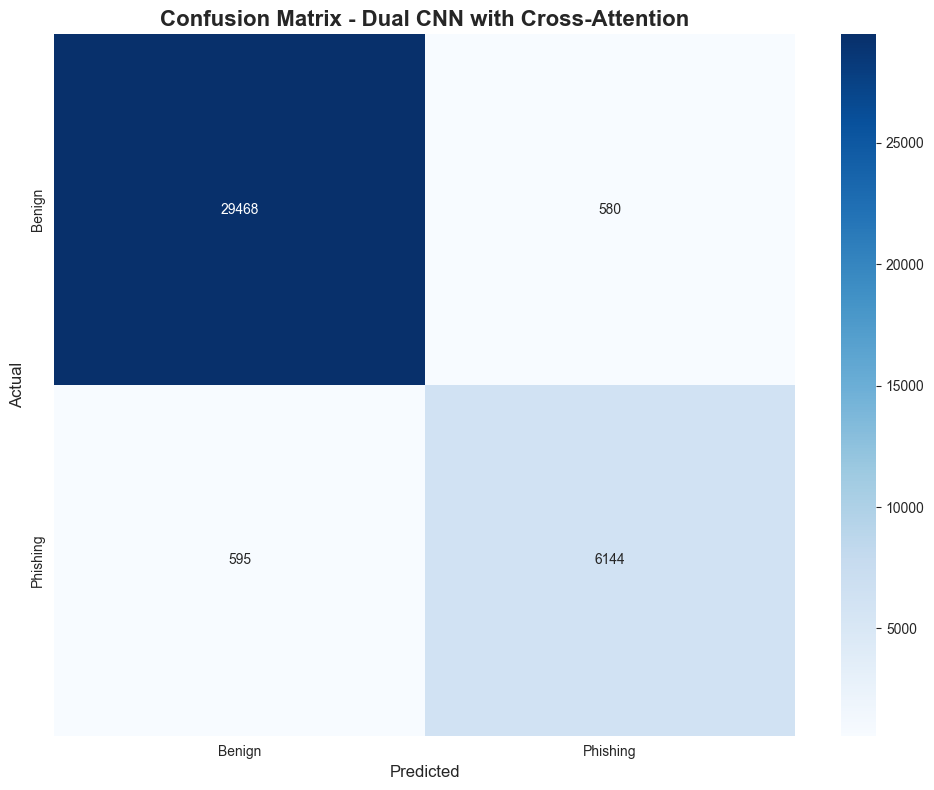

In [16]:
# ============================================
# CONFUSION MATRIX
# ============================================

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test, y_pred_optimal)

print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

fpr = cm[0,1] / (cm[0,0] + cm[0,1])
fnr = cm[1,0] / (cm[1,0] + cm[1,1])

print(f"\nFalse Positive Rate: {fpr*100:.2f}%")
print(f"False Negative Rate: {fnr*100:.2f}%")

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Phishing'],
            yticklabels=['Benign', 'Phishing'])
plt.title('Confusion Matrix - Dual CNN with Cross-Attention', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()


ROC CURVE
ROC AUC: 0.9885


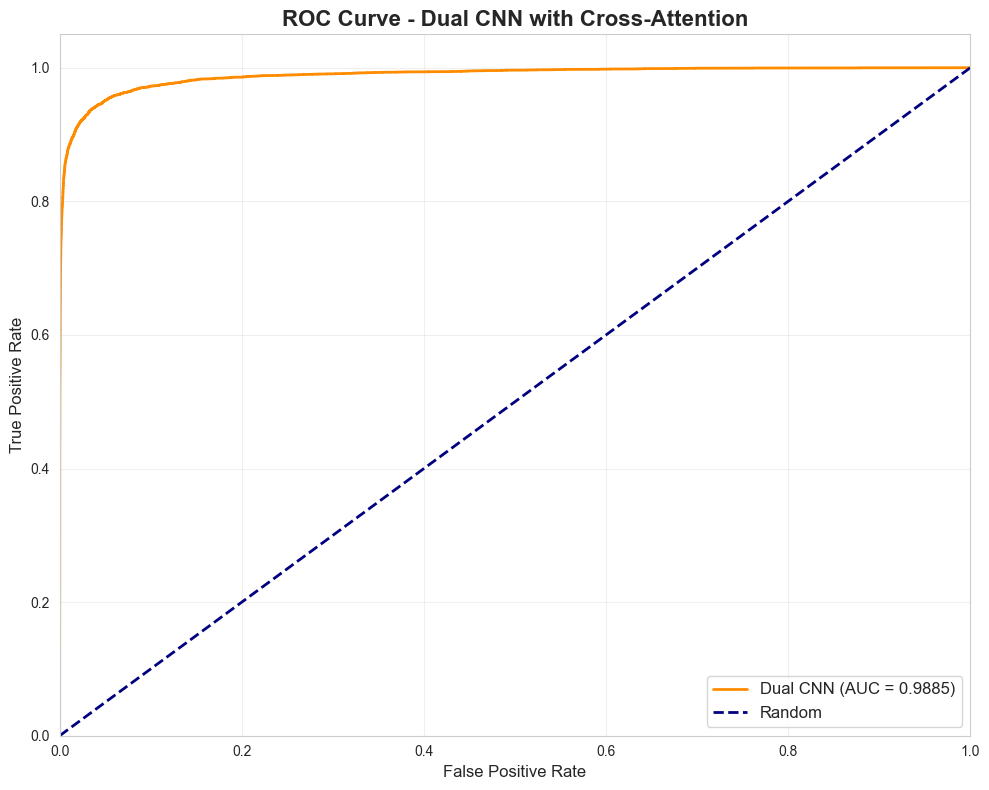

In [17]:
# ============================================
# ROC CURVE
# ============================================

print("\n" + "="*60)
print("ROC CURVE")
print("="*60)

roc_auc = roc_auc_score(y_test, y_probs)
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_probs)

print(f"ROC AUC: {roc_auc:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2,
         label=f'Dual CNN (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Dual CNN with Cross-Attention', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Save metrics
metrics = {
    'model': 'Dual CNN with Cross-Attention',
    'test_accuracy': float(final_acc),
    'test_precision': float(final_prec),
    'test_recall': float(final_rec),
    'test_f1': float(final_f1),
    'roc_auc': float(roc_auc),
    'best_epoch_f1': float(best_f1),
    'total_params': total_params,
    'trained_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metrics_df = pd.DataFrame([metrics])
metrics_path = '../../../results/url-detection/dual_cnn_cross_attention_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"Metrics saved: {metrics_path}")

Metrics saved: ../../../results/url-detection/dual_cnn_cross_attention_metrics.csv


In [22]:
# =======================================
# Save Model as TorchScript
# =======================================

print("SAVING MODEL AS TORCHSCRIPT")

model.load_state_dict(torch.load('../../../models/url-detection/dual_cnn_cross_attention_best.pth'))
model.eval()

print("Converting to TorchScript using script mode...")
scripted_model = torch.jit.script(model)

# Save TorchScript model
torchscript_path = '../../../models/url-detection/dual_cnn_cross_attention.pt'
scripted_model.save(torchscript_path)

import os
file_size = os.path.getsize(torchscript_path) / 1e6

print(f"\nSaved: {torchscript_path}")
print(f"Size: {file_size:.2f} MB")
print("\nBackend usage:")
print("  model = torch.jit.load('dual_cnn_cross_attention.pt')")
print("  model.eval()")

SAVING MODEL AS TORCHSCRIPT
Converting to TorchScript using script mode...

Saved: ../../../models/url-detection/dual_cnn_cross_attention.pt
Size: 12.84 MB

Backend usage:
  model = torch.jit.load('dual_cnn_cross_attention.pt')
  model.eval()
